In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [3]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'GOOG'
price_column = 'Close'
project_label='KerasLSTMClassification'

OUTPUT_PATH = 'results/'
N_CLASSES = 2
METRICS_PATH = f"{OUTPUT_PATH}metrics/{N_CLASSES}_classes/"
PIPELINE_LABEL = 'lstm'

THRESH_DIFF = 0.005 if N_CLASSES is 3 else None

In [4]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", thresh_diff=THRESH_DIFF,
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,0.060976,0.060866,0.064614,0.064011,0.242089,0.064011,0.016911,0.433593,0.009099,...,0.057511,0.057771,0.056349,0.581840,0.462882,0.541105,0.392573,higher,0.056271,stay
1,2007-02-22,0.063578,0.062483,0.066563,0.064008,0.246524,0.064008,0.011757,0.433481,0.011394,...,0.057686,0.057418,0.056519,0.580973,0.458111,0.533703,0.367303,stay,0.055913,stay
2,2007-02-23,0.062714,0.060363,0.064631,0.062475,0.166584,0.062475,0.022709,0.375610,0.000403,...,0.057673,0.057153,0.056455,0.573359,0.455835,0.523453,0.332589,lower,0.053115,lower
3,2007-02-26,0.061855,0.059868,0.063444,0.060808,0.170334,0.060808,0.009503,0.318246,0.008897,...,0.057764,0.056684,0.056171,0.566155,0.450778,0.522550,0.329110,lower,0.053780,higher
4,2007-02-27,0.056611,0.055376,0.058584,0.056072,0.399807,0.056072,0.012885,0.189966,0.039978,...,0.057480,0.056021,0.055274,0.546148,0.447407,0.501991,0.257379,lower,0.058645,higher


In [5]:
y_column = 'Next'
seq_len = 5
n_splits=5
val_size = 0.2

features = ['Volume', 'Close', 'LowLen', 'Difference', 'SMA(20) - SMA(10)', 'BG_H_Band_Indicator', 'MACD']
datasets_splits = data_wrapper.get_datasets(n_splits=n_splits, val_size=val_size, sequences=True, seq_len=5, y_column=y_column, features_list=features)

datasets_splits.shape

(5, 6)

<AxesSubplot:>

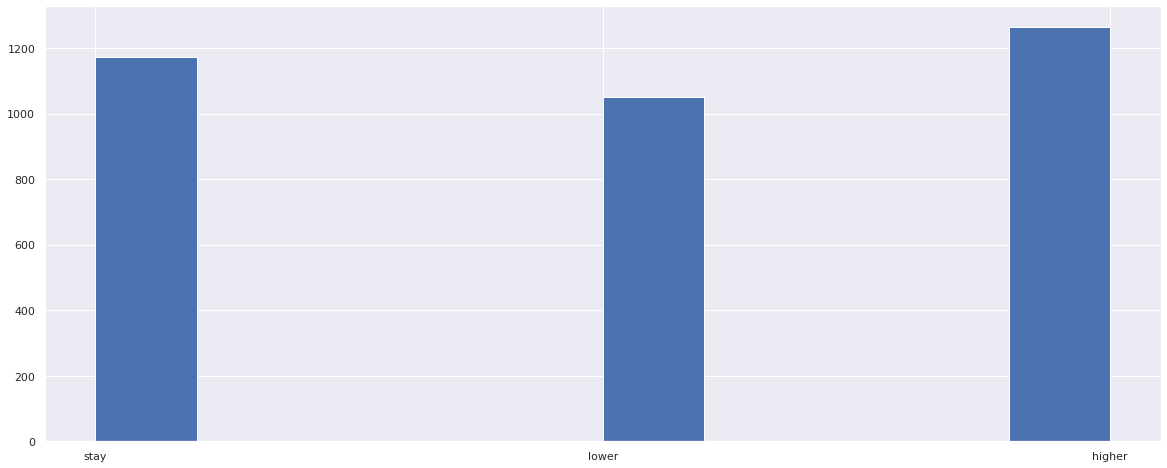

In [6]:
data_wrapper[y_column].hist()

In [7]:
PERFORM_GRID_SEARCH = True
MAX_SIZE = 5000
n_splits=5

quotations = ['AAL', 'AAPL', 'AMZN','CMCSA', 'COST', 'GM', 'GOOG', 'IBM', 'JNJ', 'KO','PEP', 'TSLA', 'WMT', 'XOM']
days_predict_feature_set = {
    1:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band', 'GAP', 'MACD_diff'],
    5:['Volume', 'Close', 'LowLen', 'Difference', 'SMA(20) - SMA(10)', 'BG_H_Band_Indicator', 'MACD'],
    10:['Volume', 'Close', 'BodyLen', 'Difference', 'SMA(20) - SMA(10)', 'EMA_Diff', 'MACD_diff'],
    20:['Volume', 'Close', 'LowLen', 'Difference', 'EMA(14)', 'BG_H_Band', 'MACD_diff'],
    50:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band','GAP','MACD_diff'],
}

#quotations=['CMCSA']
#days_predict_feature_set = {1:days_predict_feature_set[1]}

In [8]:
predict_n_metrics_dict = {}

In [9]:
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds
from trainers.keras_classification_trainer import KerasClassificationTrainer
from models.keras_lstm_model import LSTMModel
import tensorflow as tf


config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=features,
    learning_rate = 0.01,
    batch_size = 32,
    sequence_length=seq_len,
    n_epochs = 100,
    n_splits = n_splits,
    val_size = val_size,
)

for predict_n, features_list in tqdm(days_predict_feature_set.items()):
    quot_metrics_dict = {}
    for quot in tqdm(quotations):
        data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}", 
                                                   compute_features=True, 
                                                   predict_n=predict_n, 
                                                   thresh_diff=None, normalize=True)
        config_dict['quotation'] = quot


        X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                                     y_column='Next', sequences=True, seq_len=5,
                                                                     features_list=features_list)
        n_classes = len(np.unique(y_train))
    
        train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
        test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

        model = LSTMModel(config_dict, seq_len, len(features), output_dim=len(np.unique(y_train)),
                          learning_rate=config_dict['learning_rate'], loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        trainer = KerasClassificationTrainer(model, use_wandb=False, project_label=project_label)
        trainer.train(train_set)
        
        metrics = trainer.evaluate(test_set)
        label_dict = {'LSTM':metrics}
        quot_metrics_dict[quot] = label_dict
        
    predict_n_metrics_dict[predict_n] = quot_metrics_dict.copy()
        

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [10]:
print(predict_n_metrics_dict)

{1: {'AAL': {'LSTM': {'acc': 0.5329512893982808, 'f1': 0.37057547599282326}}, 'AAPL': {'LSTM': {'acc': 0.5501432664756447, 'f1': 0.39048986012319326}}, 'AMZN': {'LSTM': {'acc': 0.5472779369627507, 'f1': 0.38714846651809404}}, 'CMCSA': {'LSTM': {'acc': 0.5286746987951807, 'f1': 0.36567222230662877}}, 'COST': {'LSTM': {'acc': 0.5392938496583144, 'f1': 0.37788477663812337}}, 'GM': {'LSTM': {'acc': 0.5139442231075697, 'f1': 0.3489410777940868}}, 'GOOG': {'LSTM': {'acc': 0.5386819484240688, 'f1': 0.37717767710884514}}, 'IBM': {'LSTM': {'acc': 0.5133491044271713, 'f1': 0.3482703392697067}}, 'JNJ': {'LSTM': {'acc': 0.5257879656160458, 'f1': 0.36237405329781935}}, 'KO': {'LSTM': {'acc': 0.48424068767908307, 'f1': 0.3159717228485137}}, 'PEP': {'LSTM': {'acc': 0.476904376012966, 'f1': 0.30799256546900466}}, 'TSLA': {'LSTM': {'acc': 0.4559386973180077, 'f1': 0.2855616051623311}}, 'WMT': {'LSTM': {'acc': 0.49140401146131807, 'f1': 0.323826274603712}}, 'XOM': {'LSTM': {'acc': 0.5300859598853869, 'f

### Add to metrics

In [11]:
save_dict(dict_save=predict_n_metrics_dict, path=f"{METRICS_PATH}{PIPELINE_LABEL}_dict.txt")

In [12]:
previous_metrics = read_dict(f"{METRICS_PATH}full_metrics_dict.txt")

previous_metrics = {int(k):v for k,v in previous_metrics.items()}
previous_metrics[1]

In [13]:
full_metrics = previous_metrics.copy()
merge_metric_dicts(full_metrics, predict_n_metrics_dict)
        
save_dict(full_metrics, f"{METRICS_PATH}full_metrics_dict.txt")

In [16]:
for predict_n, quot_metrics in full_metrics.items():
    metrics_df = pd.DataFrame.from_dict(quot_metrics).T
    #print(metrics_df)
    acc_df = metrics_df.applymap(lambda metrics: metrics['acc'])
    f1_df = metrics_df.applymap(lambda metrics: metrics['f1'])
    
    plt.figure()
    acc_heatmap = sns.heatmap(acc_df, cmap ='mako', linewidths = 0.5, annot = True)
    acc_heatmap.figure.savefig(f"{METRICS_PATH}{predict_n}_acc.png")
    plt.close()
    
    plt.figure()
    f1_heatmap = sns.heatmap(f1_df, cmap ='mako', linewidths = 0.5, annot = True)
    f1_heatmap.figure.savefig(f"{METRICS_PATH}{predict_n}_f1.png")
    plt.close()